In [1]:
# !pip install pycocotools --quiet
# !git clone https://github.com/pytorch/vision.git
# !git checkout v0.3.0

# !cp vision/references/detection/utils.py ./
# !cp vision/references/detection/transforms.py ./
# !cp vision/references/detection/coco_eval.py ./
# !cp vision/references/detection/engine.py ./
# !cp vision/references/detection/coco_utils.py ./

In [2]:
import os
import numpy as np
import torch as tc
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.notebook import tqdm, trange
import pickle

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
# import transforms as T
#import cv2
from WishDataSet import WishDataSet, get_transform
from wish_utils import *

In [3]:
tc.__version__

'2.2.1+cu118'

In [4]:
tc.cuda.is_available(), tc.cuda.device_count()

(True, 2)

In [5]:
!nvidia-smi

Thu Mar  7 16:24:28 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro RTX 4000                Off |   00000000:04:00.0 Off |                  N/A |
| 31%   49C    P8             15W /  125W |    3355MiB /   8192MiB |      7%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
tc.cuda.current_device(), tc.cuda.device(0), tc.cuda.get_device_name()

(0, <torch.cuda.device at 0x7f4fdfaca4d0>, 'Quadro RTX 4000')

In [7]:
# f = "/home/wj1132075/Desktop/CNN_Model_Data/Annotations/annot_56_25.pickle"
# with open(f, 'rb') as handle:
#     annot_dict = pickle.load(handle)
#     bin_data = np.load(annot_dict['nparr_path'])['arr_0']
#     # img_res = np.tile(bin_data[:,:,None], 3)
#     bin_data = cv2.normalize(bin_data, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
#     # img_res = cv2.resize(img_res, (128, 128), cv2.INTER_AREA)

In [8]:
# annotations_dir = "/home/wj1132075/Desktop/CNN_Model_Data/PeakDataInFullRange/Annotations/"
annotations_dir = "/home/wj1132075/Desktop/CNN_Model_Data/PeakDataOnlyAtCenter/Annotations/"
ds = WishDataSet(annotations_dir)
len(ds)

2000

In [9]:
im, tar = ds[0]
type(im), type(tar)

(numpy.ndarray, dict)

In [10]:
im.shape

(1520, 128, 3)

In [11]:
tar

{'boxes': tensor([[ 0., 62.,  7., 68.]]),
 'labels': tensor([1]),
 'area': tensor([42.]),
 'iscrowd': tensor([0]),
 'image_id': 0}

### See bins and boxes

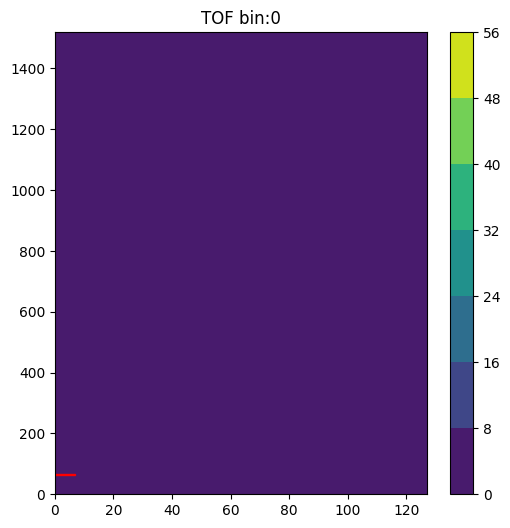

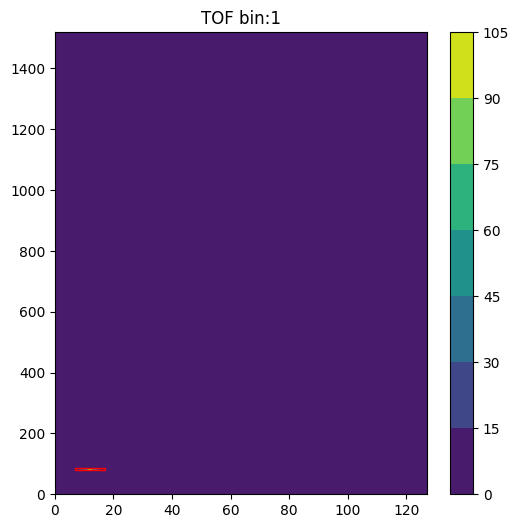

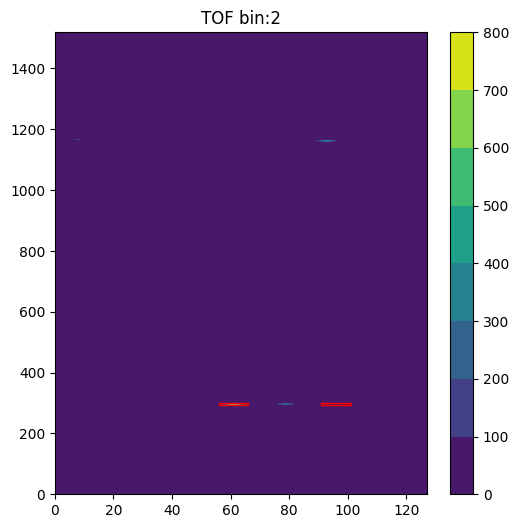

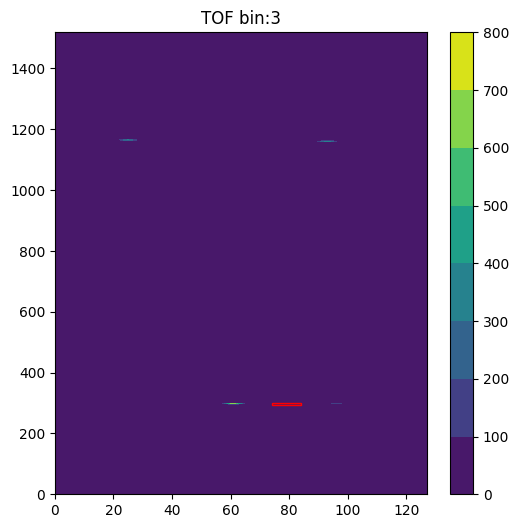

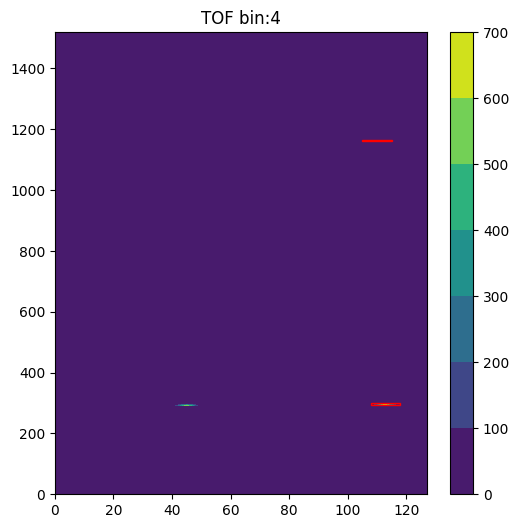

In [12]:
i=0
for (im, tar) in ds:
    plot_bin(im[:,:,0], tar['boxes'], i)
    i+=1
    if i == 5:
        break

### Calculate the stats

dl = tc.utils.data.DataLoader(ds, batch_size=100, shuffle=False, num_workers=2, collate_fn=utils.collate_fn)
stats = get_stats(dl)
stats

In [13]:
# statsold = (np.array([1.26653515, 1.26653515, 1.26653515]), np.array([4.59509826, 4.59509826, 4.59509826]))
stats = (np.array([1.47101333, 1.47101333, 1.47101333]), np.array([4.50738405, 4.50738405, 4.50738405]))
stats

(array([1.47101333, 1.47101333, 1.47101333]),
 array([4.50738405, 4.50738405, 4.50738405]))

### Training and test data sets

In [14]:
# stats=None
dataset = WishDataSet(annotations_dir, transforms=get_transform(train=True))
dataset_test = WishDataSet(annotations_dir, transforms=get_transform(train=False))

In [15]:
# split the dataset in train and test set
tc.manual_seed(1)
indices = tc.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = tc.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = tc.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = tc.utils.data.DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2, collate_fn=utils.collate_fn)
data_loader_test = tc.utils.data.DataLoader(dataset_test, batch_size=8, shuffle=False, num_workers=2, collate_fn=utils.collate_fn)

### Model Training

In [16]:
# to train on gpu if selected.
device = tc.device('cuda:1') if tc.cuda.is_available() else tc.device('cpu')

num_classes = 2

# model = get_model(model=torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights=torchvision.models.detection.FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT),
#                  num_classes=2,
#                  stats=None)
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [17]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [18]:
freeze_to(model, False)

In [19]:
device

device(type='cuda', index=1)

In [20]:
[p.requires_grad for p in model.parameters()]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [21]:
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]

optimizer = tc.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# optimizer = tc.optim.Adam(params, lr=0.005, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = tc.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=3,
                                            gamma=0.1)# to train on gpu if selected.

In [22]:
len(params)

72

In [23]:
lr_scheduler

### Training 

In [24]:
num_epochs = 20
for epoch in trange(num_epochs):
    # training for one epoch
    print(f"starting epoch {epoch}")
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

starting epoch 0
Epoch: [0]  [  0/200]  eta: 0:05:24  lr: 0.000030  loss: 12.2844 (12.2844)  loss_classifier: 2.2291 (2.2291)  loss_box_reg: 0.0667 (0.0667)  loss_objectness: 0.9492 (0.9492)  loss_rpn_box_reg: 9.0395 (9.0395)  time: 1.6249  data: 0.4389  max mem: 0
Epoch: [0]  [ 50/200]  eta: 0:01:09  lr: 0.001285  loss: 1.3709 (2.9614)  loss_classifier: 0.0111 (0.2234)  loss_box_reg: 0.0319 (0.0486)  loss_objectness: 0.5678 (0.6260)  loss_rpn_box_reg: 0.7412 (2.0634)  time: 0.4407  data: 0.0295  max mem: 0
Epoch: [0]  [100/200]  eta: 0:00:45  lr: 0.002540  loss: 0.8561 (2.0409)  loss_classifier: 0.0051 (0.1170)  loss_box_reg: 0.0187 (0.0420)  loss_objectness: 0.2647 (0.5023)  loss_rpn_box_reg: 0.6131 (1.3796)  time: 0.4410  data: 0.0271  max mem: 0
Epoch: [0]  [150/200]  eta: 0:00:22  lr: 0.003795  loss: 0.7386 (1.6393)  loss_classifier: 0.0051 (0.0819)  loss_box_reg: 0.0156 (0.0348)  loss_objectness: 0.1145 (0.3905)  loss_rpn_box_reg: 0.5986 (1.1321)  time: 0.4406  data: 0.0267  max 

In [25]:
%tb

No traceback available to show.


#### Save the trained model

In [26]:
model_save_path = '/mnt/ceph/home/wj1132075/Desktop/CNN_Model_Data/temp_fasterrcnn_mobilenet_v3_large_320_fpn_pretrained_retrained_full_4x10box.pt'

In [27]:
tc.save(model.state_dict(), model_save_path)

In [28]:
img, target = dataset_test[5]
# put the model in evaluation mode
model.eval()
with tc.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  2
real #boxes:  1


In [29]:
prediction

{'boxes': tensor([[  41.2605, 1072.9861,   50.8589, 1078.9846],
         [ 108.7947, 1074.6990,  119.1324, 1080.7069]], device='cuda:1'),
 'labels': tensor([1, 1], device='cuda:1'),
 'scores': tensor([0.9801, 0.8968], device='cuda:1')}

In [30]:
target

{'boxes': tensor([[  40., 1072.,   50., 1078.]]),
 'labels': tensor([1]),
 'area': tensor([60.]),
 'iscrowd': tensor([0]),
 'image_id': 1786}

In [31]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
nms_prediction

{'boxes': tensor([[  41.2605, 1072.9861,   50.8589, 1078.9846],
         [ 108.7947, 1074.6990,  119.1324, 1080.7069]], device='cuda:1'),
 'labels': tensor([1, 1], device='cuda:1'),
 'scores': tensor([0.9801, 0.8968], device='cuda:1')}

In [32]:
img.shape

torch.Size([3, 1520, 128])

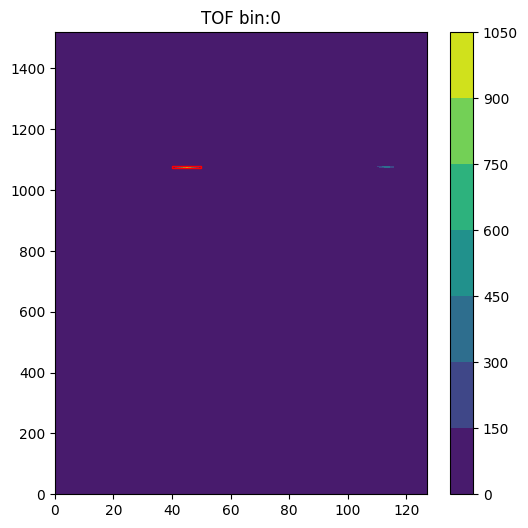

In [33]:
plot_bin(img[0,:,:], target['boxes'], 0)

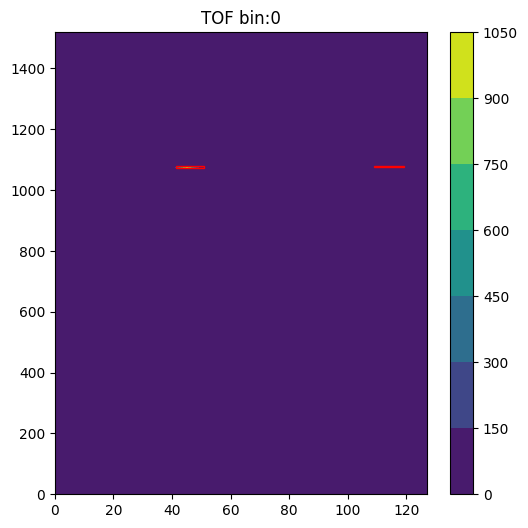

In [34]:
plot_bin(img[0,:,:], nms_prediction['boxes'].cpu(), 0)

### Load the model from disk

In [35]:
r_model = get_model(model=torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights=torchvision.models.detection.FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT),
                 num_classes=2,
                 stats=stats)
r_model.load_state_dict(tc.load(model_save_path, map_location=tc.device('cpu')))
r_model = r_model.to(device)

RuntimeError: Error(s) in loading state_dict for FasterRCNN:
	Missing key(s) in state_dict: "backbone.body.0.0.weight", "backbone.body.0.1.weight", "backbone.body.0.1.bias", "backbone.body.0.1.running_mean", "backbone.body.0.1.running_var", "backbone.body.1.block.0.0.weight", "backbone.body.1.block.0.1.weight", "backbone.body.1.block.0.1.bias", "backbone.body.1.block.0.1.running_mean", "backbone.body.1.block.0.1.running_var", "backbone.body.1.block.1.0.weight", "backbone.body.1.block.1.1.weight", "backbone.body.1.block.1.1.bias", "backbone.body.1.block.1.1.running_mean", "backbone.body.1.block.1.1.running_var", "backbone.body.2.block.0.0.weight", "backbone.body.2.block.0.1.weight", "backbone.body.2.block.0.1.bias", "backbone.body.2.block.0.1.running_mean", "backbone.body.2.block.0.1.running_var", "backbone.body.2.block.1.0.weight", "backbone.body.2.block.1.1.weight", "backbone.body.2.block.1.1.bias", "backbone.body.2.block.1.1.running_mean", "backbone.body.2.block.1.1.running_var", "backbone.body.2.block.2.0.weight", "backbone.body.2.block.2.1.weight", "backbone.body.2.block.2.1.bias", "backbone.body.2.block.2.1.running_mean", "backbone.body.2.block.2.1.running_var", "backbone.body.3.block.0.0.weight", "backbone.body.3.block.0.1.weight", "backbone.body.3.block.0.1.bias", "backbone.body.3.block.0.1.running_mean", "backbone.body.3.block.0.1.running_var", "backbone.body.3.block.1.0.weight", "backbone.body.3.block.1.1.weight", "backbone.body.3.block.1.1.bias", "backbone.body.3.block.1.1.running_mean", "backbone.body.3.block.1.1.running_var", "backbone.body.3.block.2.0.weight", "backbone.body.3.block.2.1.weight", "backbone.body.3.block.2.1.bias", "backbone.body.3.block.2.1.running_mean", "backbone.body.3.block.2.1.running_var", "backbone.body.4.block.0.0.weight", "backbone.body.4.block.0.1.weight", "backbone.body.4.block.0.1.bias", "backbone.body.4.block.0.1.running_mean", "backbone.body.4.block.0.1.running_var", "backbone.body.4.block.1.0.weight", "backbone.body.4.block.1.1.weight", "backbone.body.4.block.1.1.bias", "backbone.body.4.block.1.1.running_mean", "backbone.body.4.block.1.1.running_var", "backbone.body.4.block.2.fc1.weight", "backbone.body.4.block.2.fc1.bias", "backbone.body.4.block.2.fc2.weight", "backbone.body.4.block.2.fc2.bias", "backbone.body.4.block.3.0.weight", "backbone.body.4.block.3.1.weight", "backbone.body.4.block.3.1.bias", "backbone.body.4.block.3.1.running_mean", "backbone.body.4.block.3.1.running_var", "backbone.body.5.block.0.0.weight", "backbone.body.5.block.0.1.weight", "backbone.body.5.block.0.1.bias", "backbone.body.5.block.0.1.running_mean", "backbone.body.5.block.0.1.running_var", "backbone.body.5.block.1.0.weight", "backbone.body.5.block.1.1.weight", "backbone.body.5.block.1.1.bias", "backbone.body.5.block.1.1.running_mean", "backbone.body.5.block.1.1.running_var", "backbone.body.5.block.2.fc1.weight", "backbone.body.5.block.2.fc1.bias", "backbone.body.5.block.2.fc2.weight", "backbone.body.5.block.2.fc2.bias", "backbone.body.5.block.3.0.weight", "backbone.body.5.block.3.1.weight", "backbone.body.5.block.3.1.bias", "backbone.body.5.block.3.1.running_mean", "backbone.body.5.block.3.1.running_var", "backbone.body.6.block.0.0.weight", "backbone.body.6.block.0.1.weight", "backbone.body.6.block.0.1.bias", "backbone.body.6.block.0.1.running_mean", "backbone.body.6.block.0.1.running_var", "backbone.body.6.block.1.0.weight", "backbone.body.6.block.1.1.weight", "backbone.body.6.block.1.1.bias", "backbone.body.6.block.1.1.running_mean", "backbone.body.6.block.1.1.running_var", "backbone.body.6.block.2.fc1.weight", "backbone.body.6.block.2.fc1.bias", "backbone.body.6.block.2.fc2.weight", "backbone.body.6.block.2.fc2.bias", "backbone.body.6.block.3.0.weight", "backbone.body.6.block.3.1.weight", "backbone.body.6.block.3.1.bias", "backbone.body.6.block.3.1.running_mean", "backbone.body.6.block.3.1.running_var", "backbone.body.7.block.0.0.weight", "backbone.body.7.block.0.1.weight", "backbone.body.7.block.0.1.bias", "backbone.body.7.block.0.1.running_mean", "backbone.body.7.block.0.1.running_var", "backbone.body.7.block.1.0.weight", "backbone.body.7.block.1.1.weight", "backbone.body.7.block.1.1.bias", "backbone.body.7.block.1.1.running_mean", "backbone.body.7.block.1.1.running_var", "backbone.body.7.block.2.0.weight", "backbone.body.7.block.2.1.weight", "backbone.body.7.block.2.1.bias", "backbone.body.7.block.2.1.running_mean", "backbone.body.7.block.2.1.running_var", "backbone.body.8.block.0.0.weight", "backbone.body.8.block.0.1.weight", "backbone.body.8.block.0.1.bias", "backbone.body.8.block.0.1.running_mean", "backbone.body.8.block.0.1.running_var", "backbone.body.8.block.1.0.weight", "backbone.body.8.block.1.1.weight", "backbone.body.8.block.1.1.bias", "backbone.body.8.block.1.1.running_mean", "backbone.body.8.block.1.1.running_var", "backbone.body.8.block.2.0.weight", "backbone.body.8.block.2.1.weight", "backbone.body.8.block.2.1.bias", "backbone.body.8.block.2.1.running_mean", "backbone.body.8.block.2.1.running_var", "backbone.body.9.block.0.0.weight", "backbone.body.9.block.0.1.weight", "backbone.body.9.block.0.1.bias", "backbone.body.9.block.0.1.running_mean", "backbone.body.9.block.0.1.running_var", "backbone.body.9.block.1.0.weight", "backbone.body.9.block.1.1.weight", "backbone.body.9.block.1.1.bias", "backbone.body.9.block.1.1.running_mean", "backbone.body.9.block.1.1.running_var", "backbone.body.9.block.2.0.weight", "backbone.body.9.block.2.1.weight", "backbone.body.9.block.2.1.bias", "backbone.body.9.block.2.1.running_mean", "backbone.body.9.block.2.1.running_var", "backbone.body.10.block.0.0.weight", "backbone.body.10.block.0.1.weight", "backbone.body.10.block.0.1.bias", "backbone.body.10.block.0.1.running_mean", "backbone.body.10.block.0.1.running_var", "backbone.body.10.block.1.0.weight", "backbone.body.10.block.1.1.weight", "backbone.body.10.block.1.1.bias", "backbone.body.10.block.1.1.running_mean", "backbone.body.10.block.1.1.running_var", "backbone.body.10.block.2.0.weight", "backbone.body.10.block.2.1.weight", "backbone.body.10.block.2.1.bias", "backbone.body.10.block.2.1.running_mean", "backbone.body.10.block.2.1.running_var", "backbone.body.11.block.0.0.weight", "backbone.body.11.block.0.1.weight", "backbone.body.11.block.0.1.bias", "backbone.body.11.block.0.1.running_mean", "backbone.body.11.block.0.1.running_var", "backbone.body.11.block.1.0.weight", "backbone.body.11.block.1.1.weight", "backbone.body.11.block.1.1.bias", "backbone.body.11.block.1.1.running_mean", "backbone.body.11.block.1.1.running_var", "backbone.body.11.block.2.fc1.weight", "backbone.body.11.block.2.fc1.bias", "backbone.body.11.block.2.fc2.weight", "backbone.body.11.block.2.fc2.bias", "backbone.body.11.block.3.0.weight", "backbone.body.11.block.3.1.weight", "backbone.body.11.block.3.1.bias", "backbone.body.11.block.3.1.running_mean", "backbone.body.11.block.3.1.running_var", "backbone.body.12.block.0.0.weight", "backbone.body.12.block.0.1.weight", "backbone.body.12.block.0.1.bias", "backbone.body.12.block.0.1.running_mean", "backbone.body.12.block.0.1.running_var", "backbone.body.12.block.1.0.weight", "backbone.body.12.block.1.1.weight", "backbone.body.12.block.1.1.bias", "backbone.body.12.block.1.1.running_mean", "backbone.body.12.block.1.1.running_var", "backbone.body.12.block.2.fc1.weight", "backbone.body.12.block.2.fc1.bias", "backbone.body.12.block.2.fc2.weight", "backbone.body.12.block.2.fc2.bias", "backbone.body.12.block.3.0.weight", "backbone.body.12.block.3.1.weight", "backbone.body.12.block.3.1.bias", "backbone.body.12.block.3.1.running_mean", "backbone.body.12.block.3.1.running_var", "backbone.body.13.block.0.0.weight", "backbone.body.13.block.0.1.weight", "backbone.body.13.block.0.1.bias", "backbone.body.13.block.0.1.running_mean", "backbone.body.13.block.0.1.running_var", "backbone.body.13.block.1.0.weight", "backbone.body.13.block.1.1.weight", "backbone.body.13.block.1.1.bias", "backbone.body.13.block.1.1.running_mean", "backbone.body.13.block.1.1.running_var", "backbone.body.13.block.2.fc1.weight", "backbone.body.13.block.2.fc1.bias", "backbone.body.13.block.2.fc2.weight", "backbone.body.13.block.2.fc2.bias", "backbone.body.13.block.3.0.weight", "backbone.body.13.block.3.1.weight", "backbone.body.13.block.3.1.bias", "backbone.body.13.block.3.1.running_mean", "backbone.body.13.block.3.1.running_var", "backbone.body.14.block.0.0.weight", "backbone.body.14.block.0.1.weight", "backbone.body.14.block.0.1.bias", "backbone.body.14.block.0.1.running_mean", "backbone.body.14.block.0.1.running_var", "backbone.body.14.block.1.0.weight", "backbone.body.14.block.1.1.weight", "backbone.body.14.block.1.1.bias", "backbone.body.14.block.1.1.running_mean", "backbone.body.14.block.1.1.running_var", "backbone.body.14.block.2.fc1.weight", "backbone.body.14.block.2.fc1.bias", "backbone.body.14.block.2.fc2.weight", "backbone.body.14.block.2.fc2.bias", "backbone.body.14.block.3.0.weight", "backbone.body.14.block.3.1.weight", "backbone.body.14.block.3.1.bias", "backbone.body.14.block.3.1.running_mean", "backbone.body.14.block.3.1.running_var", "backbone.body.15.block.0.0.weight", "backbone.body.15.block.0.1.weight", "backbone.body.15.block.0.1.bias", "backbone.body.15.block.0.1.running_mean", "backbone.body.15.block.0.1.running_var", "backbone.body.15.block.1.0.weight", "backbone.body.15.block.1.1.weight", "backbone.body.15.block.1.1.bias", "backbone.body.15.block.1.1.running_mean", "backbone.body.15.block.1.1.running_var", "backbone.body.15.block.2.fc1.weight", "backbone.body.15.block.2.fc1.bias", "backbone.body.15.block.2.fc2.weight", "backbone.body.15.block.2.fc2.bias", "backbone.body.15.block.3.0.weight", "backbone.body.15.block.3.1.weight", "backbone.body.15.block.3.1.bias", "backbone.body.15.block.3.1.running_mean", "backbone.body.15.block.3.1.running_var", "backbone.body.16.0.weight", "backbone.body.16.1.weight", "backbone.body.16.1.bias", "backbone.body.16.1.running_mean", "backbone.body.16.1.running_var". 
	Unexpected key(s) in state_dict: "backbone.body.conv1.weight", "backbone.body.bn1.weight", "backbone.body.bn1.bias", "backbone.body.bn1.running_mean", "backbone.body.bn1.running_var", "backbone.body.layer1.0.conv1.weight", "backbone.body.layer1.0.bn1.weight", "backbone.body.layer1.0.bn1.bias", "backbone.body.layer1.0.bn1.running_mean", "backbone.body.layer1.0.bn1.running_var", "backbone.body.layer1.0.conv2.weight", "backbone.body.layer1.0.bn2.weight", "backbone.body.layer1.0.bn2.bias", "backbone.body.layer1.0.bn2.running_mean", "backbone.body.layer1.0.bn2.running_var", "backbone.body.layer1.0.conv3.weight", "backbone.body.layer1.0.bn3.weight", "backbone.body.layer1.0.bn3.bias", "backbone.body.layer1.0.bn3.running_mean", "backbone.body.layer1.0.bn3.running_var", "backbone.body.layer1.0.downsample.0.weight", "backbone.body.layer1.0.downsample.1.weight", "backbone.body.layer1.0.downsample.1.bias", "backbone.body.layer1.0.downsample.1.running_mean", "backbone.body.layer1.0.downsample.1.running_var", "backbone.body.layer1.1.conv1.weight", "backbone.body.layer1.1.bn1.weight", "backbone.body.layer1.1.bn1.bias", "backbone.body.layer1.1.bn1.running_mean", "backbone.body.layer1.1.bn1.running_var", "backbone.body.layer1.1.conv2.weight", "backbone.body.layer1.1.bn2.weight", "backbone.body.layer1.1.bn2.bias", "backbone.body.layer1.1.bn2.running_mean", "backbone.body.layer1.1.bn2.running_var", "backbone.body.layer1.1.conv3.weight", "backbone.body.layer1.1.bn3.weight", "backbone.body.layer1.1.bn3.bias", "backbone.body.layer1.1.bn3.running_mean", "backbone.body.layer1.1.bn3.running_var", "backbone.body.layer1.2.conv1.weight", "backbone.body.layer1.2.bn1.weight", "backbone.body.layer1.2.bn1.bias", "backbone.body.layer1.2.bn1.running_mean", "backbone.body.layer1.2.bn1.running_var", "backbone.body.layer1.2.conv2.weight", "backbone.body.layer1.2.bn2.weight", "backbone.body.layer1.2.bn2.bias", "backbone.body.layer1.2.bn2.running_mean", "backbone.body.layer1.2.bn2.running_var", "backbone.body.layer1.2.conv3.weight", "backbone.body.layer1.2.bn3.weight", "backbone.body.layer1.2.bn3.bias", "backbone.body.layer1.2.bn3.running_mean", "backbone.body.layer1.2.bn3.running_var", "backbone.body.layer2.0.conv1.weight", "backbone.body.layer2.0.bn1.weight", "backbone.body.layer2.0.bn1.bias", "backbone.body.layer2.0.bn1.running_mean", "backbone.body.layer2.0.bn1.running_var", "backbone.body.layer2.0.conv2.weight", "backbone.body.layer2.0.bn2.weight", "backbone.body.layer2.0.bn2.bias", "backbone.body.layer2.0.bn2.running_mean", "backbone.body.layer2.0.bn2.running_var", "backbone.body.layer2.0.conv3.weight", "backbone.body.layer2.0.bn3.weight", "backbone.body.layer2.0.bn3.bias", "backbone.body.layer2.0.bn3.running_mean", "backbone.body.layer2.0.bn3.running_var", "backbone.body.layer2.0.downsample.0.weight", "backbone.body.layer2.0.downsample.1.weight", "backbone.body.layer2.0.downsample.1.bias", "backbone.body.layer2.0.downsample.1.running_mean", "backbone.body.layer2.0.downsample.1.running_var", "backbone.body.layer2.1.conv1.weight", "backbone.body.layer2.1.bn1.weight", "backbone.body.layer2.1.bn1.bias", "backbone.body.layer2.1.bn1.running_mean", "backbone.body.layer2.1.bn1.running_var", "backbone.body.layer2.1.conv2.weight", "backbone.body.layer2.1.bn2.weight", "backbone.body.layer2.1.bn2.bias", "backbone.body.layer2.1.bn2.running_mean", "backbone.body.layer2.1.bn2.running_var", "backbone.body.layer2.1.conv3.weight", "backbone.body.layer2.1.bn3.weight", "backbone.body.layer2.1.bn3.bias", "backbone.body.layer2.1.bn3.running_mean", "backbone.body.layer2.1.bn3.running_var", "backbone.body.layer2.2.conv1.weight", "backbone.body.layer2.2.bn1.weight", "backbone.body.layer2.2.bn1.bias", "backbone.body.layer2.2.bn1.running_mean", "backbone.body.layer2.2.bn1.running_var", "backbone.body.layer2.2.conv2.weight", "backbone.body.layer2.2.bn2.weight", "backbone.body.layer2.2.bn2.bias", "backbone.body.layer2.2.bn2.running_mean", "backbone.body.layer2.2.bn2.running_var", "backbone.body.layer2.2.conv3.weight", "backbone.body.layer2.2.bn3.weight", "backbone.body.layer2.2.bn3.bias", "backbone.body.layer2.2.bn3.running_mean", "backbone.body.layer2.2.bn3.running_var", "backbone.body.layer2.3.conv1.weight", "backbone.body.layer2.3.bn1.weight", "backbone.body.layer2.3.bn1.bias", "backbone.body.layer2.3.bn1.running_mean", "backbone.body.layer2.3.bn1.running_var", "backbone.body.layer2.3.conv2.weight", "backbone.body.layer2.3.bn2.weight", "backbone.body.layer2.3.bn2.bias", "backbone.body.layer2.3.bn2.running_mean", "backbone.body.layer2.3.bn2.running_var", "backbone.body.layer2.3.conv3.weight", "backbone.body.layer2.3.bn3.weight", "backbone.body.layer2.3.bn3.bias", "backbone.body.layer2.3.bn3.running_mean", "backbone.body.layer2.3.bn3.running_var", "backbone.body.layer3.0.conv1.weight", "backbone.body.layer3.0.bn1.weight", "backbone.body.layer3.0.bn1.bias", "backbone.body.layer3.0.bn1.running_mean", "backbone.body.layer3.0.bn1.running_var", "backbone.body.layer3.0.conv2.weight", "backbone.body.layer3.0.bn2.weight", "backbone.body.layer3.0.bn2.bias", "backbone.body.layer3.0.bn2.running_mean", "backbone.body.layer3.0.bn2.running_var", "backbone.body.layer3.0.conv3.weight", "backbone.body.layer3.0.bn3.weight", "backbone.body.layer3.0.bn3.bias", "backbone.body.layer3.0.bn3.running_mean", "backbone.body.layer3.0.bn3.running_var", "backbone.body.layer3.0.downsample.0.weight", "backbone.body.layer3.0.downsample.1.weight", "backbone.body.layer3.0.downsample.1.bias", "backbone.body.layer3.0.downsample.1.running_mean", "backbone.body.layer3.0.downsample.1.running_var", "backbone.body.layer3.1.conv1.weight", "backbone.body.layer3.1.bn1.weight", "backbone.body.layer3.1.bn1.bias", "backbone.body.layer3.1.bn1.running_mean", "backbone.body.layer3.1.bn1.running_var", "backbone.body.layer3.1.conv2.weight", "backbone.body.layer3.1.bn2.weight", "backbone.body.layer3.1.bn2.bias", "backbone.body.layer3.1.bn2.running_mean", "backbone.body.layer3.1.bn2.running_var", "backbone.body.layer3.1.conv3.weight", "backbone.body.layer3.1.bn3.weight", "backbone.body.layer3.1.bn3.bias", "backbone.body.layer3.1.bn3.running_mean", "backbone.body.layer3.1.bn3.running_var", "backbone.body.layer3.2.conv1.weight", "backbone.body.layer3.2.bn1.weight", "backbone.body.layer3.2.bn1.bias", "backbone.body.layer3.2.bn1.running_mean", "backbone.body.layer3.2.bn1.running_var", "backbone.body.layer3.2.conv2.weight", "backbone.body.layer3.2.bn2.weight", "backbone.body.layer3.2.bn2.bias", "backbone.body.layer3.2.bn2.running_mean", "backbone.body.layer3.2.bn2.running_var", "backbone.body.layer3.2.conv3.weight", "backbone.body.layer3.2.bn3.weight", "backbone.body.layer3.2.bn3.bias", "backbone.body.layer3.2.bn3.running_mean", "backbone.body.layer3.2.bn3.running_var", "backbone.body.layer3.3.conv1.weight", "backbone.body.layer3.3.bn1.weight", "backbone.body.layer3.3.bn1.bias", "backbone.body.layer3.3.bn1.running_mean", "backbone.body.layer3.3.bn1.running_var", "backbone.body.layer3.3.conv2.weight", "backbone.body.layer3.3.bn2.weight", "backbone.body.layer3.3.bn2.bias", "backbone.body.layer3.3.bn2.running_mean", "backbone.body.layer3.3.bn2.running_var", "backbone.body.layer3.3.conv3.weight", "backbone.body.layer3.3.bn3.weight", "backbone.body.layer3.3.bn3.bias", "backbone.body.layer3.3.bn3.running_mean", "backbone.body.layer3.3.bn3.running_var", "backbone.body.layer3.4.conv1.weight", "backbone.body.layer3.4.bn1.weight", "backbone.body.layer3.4.bn1.bias", "backbone.body.layer3.4.bn1.running_mean", "backbone.body.layer3.4.bn1.running_var", "backbone.body.layer3.4.conv2.weight", "backbone.body.layer3.4.bn2.weight", "backbone.body.layer3.4.bn2.bias", "backbone.body.layer3.4.bn2.running_mean", "backbone.body.layer3.4.bn2.running_var", "backbone.body.layer3.4.conv3.weight", "backbone.body.layer3.4.bn3.weight", "backbone.body.layer3.4.bn3.bias", "backbone.body.layer3.4.bn3.running_mean", "backbone.body.layer3.4.bn3.running_var", "backbone.body.layer3.5.conv1.weight", "backbone.body.layer3.5.bn1.weight", "backbone.body.layer3.5.bn1.bias", "backbone.body.layer3.5.bn1.running_mean", "backbone.body.layer3.5.bn1.running_var", "backbone.body.layer3.5.conv2.weight", "backbone.body.layer3.5.bn2.weight", "backbone.body.layer3.5.bn2.bias", "backbone.body.layer3.5.bn2.running_mean", "backbone.body.layer3.5.bn2.running_var", "backbone.body.layer3.5.conv3.weight", "backbone.body.layer3.5.bn3.weight", "backbone.body.layer3.5.bn3.bias", "backbone.body.layer3.5.bn3.running_mean", "backbone.body.layer3.5.bn3.running_var", "backbone.body.layer4.0.conv1.weight", "backbone.body.layer4.0.bn1.weight", "backbone.body.layer4.0.bn1.bias", "backbone.body.layer4.0.bn1.running_mean", "backbone.body.layer4.0.bn1.running_var", "backbone.body.layer4.0.conv2.weight", "backbone.body.layer4.0.bn2.weight", "backbone.body.layer4.0.bn2.bias", "backbone.body.layer4.0.bn2.running_mean", "backbone.body.layer4.0.bn2.running_var", "backbone.body.layer4.0.conv3.weight", "backbone.body.layer4.0.bn3.weight", "backbone.body.layer4.0.bn3.bias", "backbone.body.layer4.0.bn3.running_mean", "backbone.body.layer4.0.bn3.running_var", "backbone.body.layer4.0.downsample.0.weight", "backbone.body.layer4.0.downsample.1.weight", "backbone.body.layer4.0.downsample.1.bias", "backbone.body.layer4.0.downsample.1.running_mean", "backbone.body.layer4.0.downsample.1.running_var", "backbone.body.layer4.1.conv1.weight", "backbone.body.layer4.1.bn1.weight", "backbone.body.layer4.1.bn1.bias", "backbone.body.layer4.1.bn1.running_mean", "backbone.body.layer4.1.bn1.running_var", "backbone.body.layer4.1.conv2.weight", "backbone.body.layer4.1.bn2.weight", "backbone.body.layer4.1.bn2.bias", "backbone.body.layer4.1.bn2.running_mean", "backbone.body.layer4.1.bn2.running_var", "backbone.body.layer4.1.conv3.weight", "backbone.body.layer4.1.bn3.weight", "backbone.body.layer4.1.bn3.bias", "backbone.body.layer4.1.bn3.running_mean", "backbone.body.layer4.1.bn3.running_var", "backbone.body.layer4.2.conv1.weight", "backbone.body.layer4.2.bn1.weight", "backbone.body.layer4.2.bn1.bias", "backbone.body.layer4.2.bn1.running_mean", "backbone.body.layer4.2.bn1.running_var", "backbone.body.layer4.2.conv2.weight", "backbone.body.layer4.2.bn2.weight", "backbone.body.layer4.2.bn2.bias", "backbone.body.layer4.2.bn2.running_mean", "backbone.body.layer4.2.bn2.running_var", "backbone.body.layer4.2.conv3.weight", "backbone.body.layer4.2.bn3.weight", "backbone.body.layer4.2.bn3.bias", "backbone.body.layer4.2.bn3.running_mean", "backbone.body.layer4.2.bn3.running_var", "backbone.fpn.inner_blocks.2.0.weight", "backbone.fpn.inner_blocks.2.0.bias", "backbone.fpn.inner_blocks.3.0.weight", "backbone.fpn.inner_blocks.3.0.bias", "backbone.fpn.layer_blocks.2.0.weight", "backbone.fpn.layer_blocks.2.0.bias", "backbone.fpn.layer_blocks.3.0.weight", "backbone.fpn.layer_blocks.3.0.bias". 
	size mismatch for backbone.fpn.inner_blocks.0.0.weight: copying a param with shape torch.Size([256, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 160, 1, 1]).
	size mismatch for backbone.fpn.inner_blocks.1.0.weight: copying a param with shape torch.Size([256, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 960, 1, 1]).
	size mismatch for rpn.head.cls_logits.weight: copying a param with shape torch.Size([3, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([15, 256, 1, 1]).
	size mismatch for rpn.head.cls_logits.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([15]).
	size mismatch for rpn.head.bbox_pred.weight: copying a param with shape torch.Size([12, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([60, 256, 1, 1]).
	size mismatch for rpn.head.bbox_pred.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([60]).

In [ ]:
img, target = dataset_test[100]
r_model.eval()
with tc.no_grad():
    prediction = r_model([img.to(device)])[0]
prediction

In [ ]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
nms_prediction

In [ ]:
plot_bin(img[0,:,:], nms_prediction['boxes'].cpu(), 0)

In [ ]:
r_model.eval()
probe = 0
for img, target in data_loader_test:
    imgs = list(img)
    targets = list(target)
    with tc.no_grad():
        for img, target in zip(imgs, targets):
            prediction = r_model([img.to(device)])[0]
            print(prediction)
            nms_prediction = apply_nms(prediction, iou_thresh=0.001)
            print(nms_prediction)
            nms_prediction['boxes'] = nms_prediction['boxes'].cpu()
            plot_bin_detections(img[0,:,:], target['boxes'], nms_prediction)
            probe += 1

    if probe >= 1:
        break